In [1]:
from helpers import load_data, preprocess_data
from plots import plot_train_test_data
from helpers import split_data
from helpers import init_MF
from plots import plot_raw_data
from helpers import calculate_mse

# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse as sp


%load_ext autoreload
%autoreload 2

## Preprocessing..

In [2]:
path_dataset = "./data/de_data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


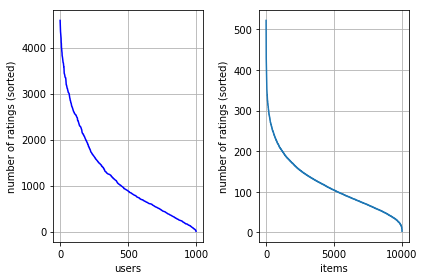

In [3]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

In [4]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059177
Total number of nonzero elements in test data:117775


### Baseline models

In [16]:
def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    global_mean = train[train.nonzero()].mean()
    nnz_test = test[test.nonzero()].todense() 
    mse = calculate_mse(nnz_test, global_mean)
    rmse = np.sqrt(mse / nnz_test.shape[1])
    return np.squeeze(rmse).item()
print("RMSE global: {}".format(baseline_global_mean(train, test)))

RMSE: 1.1217386297173755


In [26]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    _, num_users = train.shape
    for user in range(num_users):
        user_ratings_train = train[:, user]
        nnz_train = user_ratings_train[user_ratings_train.nonzero()]
        if nnz_train.shape[0] == 0:
            continue
        user_mean = nnz_train.mean()            
        user_ratings_test = test[:, user]
        nnz_test = user_ratings_test[user_ratings_test.nonzero()].todense()
        mse += calculate_mse(nnz_test, user_mean)
    return np.sqrt(1.0 * mse / test.nnz).item()
print("RMSE user-mean: {}".format(baseline_user_mean(train, test)))

RMSE user-mean: 1.0319099240955814


In [25]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    return baseline_user_mean(train.T, test.T)
print("RMSE item-mean: {}".format(baseline_item_mean(train, test)))

RMSE item-mean: 1.0959075588942098


#### Baseline estimate model

In [104]:
def compute_error_baseline_estimate(data, 
                                    nz, 
                                    user_bias, 
                                    item_bias, 
                                    global_bias,
                                    lambda_user_bias,
                                    lambda_item_bias):
    mse = 0
    for item, user in nz:
        prediction = global_bias + item_bias[item] + user_bias[user]
        mse += (data[item, user] - prediction) ** 2
    reg = lambda_user_bias * user_bias.T.dot(user_bias) + lambda_item_bias * item_bias.T.dot(item_bias)
    mse += reg
    return np.sqrt(mse / len(nz))


# See 2.1 http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf
def baseline_estimate(train,
                      test,
                      gamma=0.02, 
                      num_features=20,
                      lambda_user_bias=0.1,
                      lambda_item_bias=0.1,
                      num_epochs=10):
    
    global_bias = train[train.nonzero()].mean()
    
    # He init
    user_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[1])
    item_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[0])
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("Starting SGD...")
    for it in range(num_epochs):
        np.random.shuffle(nz_train)
        gamma /= 1.2
        for d, n in nz_train:
            prediction = global_bias + user_bias[n] + item_bias[d]
            error = train[d, n] - prediction
            # Update variables
            user_bias[n] +=  gamma * (error - lambda_user_bias * user_bias[n])
            item_bias[d] +=  gamma * (error - lambda_item_bias * item_bias[d])
        rmse = compute_error_baseline_estimate(train, 
                                               nz_train, 
                                               user_bias, 
                                               item_bias, 
                                               global_bias,
                                               lambda_user_bias,
                                               lambda_item_bias)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
    rmse = compute_error_baseline_estimate(test, 
                                           nz_test, 
                                           user_bias, 
                                           item_bias,
                                           global_bias,
                                           lambda_user_bias,
                                           lambda_item_bias)
    print("RMSE on test data: {}.".format(rmse))
    
    return user_bias, item_bias, global_bias 

user_bias, item_bias, global_bias = baseline_estimate(train, test)

Starting SGD...
iter: 0, RMSE on training set: 0.9994629076738408.
iter: 1, RMSE on training set: 0.9956075486578966.
iter: 2, RMSE on training set: 0.99370587331951.
iter: 3, RMSE on training set: 0.9930551822462327.
iter: 4, RMSE on training set: 0.9924684505310238.
iter: 5, RMSE on training set: 0.9920580299985728.
iter: 6, RMSE on training set: 0.9915115565597591.
iter: 7, RMSE on training set: 0.9913468214722916.
iter: 8, RMSE on training set: 0.9911768392951089.
iter: 9, RMSE on training set: 0.9910120783857594.
RMSE on test data: 1.001507976095007.


In [106]:
from helpers import create_submission_baseline_estimate
create_submission_baseline_estimate(user_bias, item_bias, global_bias)

## KNN

In [309]:
from helpers import build_index_groups

nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

num_items, num_users = train.shape
for user, items in nz_user_itemindices:
    user_means[user] = train[items, user].mean()

In [352]:
# Takes ~10 min to compute!
def construct_similarity_matrix(data, nz_user_userindices):
    num_items, num_users = data.shape
    print("Constructing sim matrix")
    similarity_matrix = np.zeros((num_users, num_users))
    for i, items_i in nz_user_itemindices:
        print(i)
        for j, items_j in nz_user_itemindices:
            if i == j:
                continue
                            
            item_intersection = np.intersect1d(items_i, items_j)
            
            if len(item_intersection) == 0:
                continue
            
            # Calculate pearson coefficient, could might as well have used np.corrcoef
            # but calculatig it yourself is so much more fun!
            
            r_i = data[item_intersection, i].todense()
            r_i = r_i -  r_i.mean()
            r_j = data[item_intersection, j].todense()
            r_j = r_j -  r_j.mean()
     
            numerator = r_i.T @ r_j

            denominator = np.sqrt(r_i.T.dot(r_i)) * np.sqrt(r_j.T.dot(r_j))
            similarity_matrix[i, j] = numerator / denominator if denominator > 0 else 0       
            
    return similarity_matrix

In [353]:
def construct_s_matrix(train, nz_train, user_means):
    s_matrix = sp.lil_matrix(train.shape)
    #nz_row, nz_col = train.nonzero()
    #nz_train = list(zip(nz_row, nz_col))
    print("Constructing S matrix...")
    for d, n in nz_train:
        s_matrix[d, n] = train[d, n] - user_means[n]
    return s_matrix

In [354]:
def evaluate_knn(similarity_matrix, s_matrix, test, k, nz_item_userindices, similarity_treshold=0.1):
    mse = 0
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    iters = 0
    print("Starting evaluation..")
    for d, n in nz_test:
        iters += 1
        if iters % 10000 == 0:
            print(iters)
            
        # Get index of k most similar users
        # Set all similarityis not in d_users to zero -> argsort -> take top k.
        _, d_users = nz_item_userindices[d]
        d_users_similarity = similarity_matrix[n, :].copy()
        kn_index = np.zeros(similarity_matrix.shape[1])
        kn_index[d_users] = similarity_matrix[n, d_users]
        kn_index = kn_index.argsort()[-k:][::-1]

        kn_similarity = kn_similarity[n, kn_index] 
        
        kn_mean_centered_rating = s_matrix[d, kn_index].todense()
        kn_mean_centered_rating = np.squeeze(np.asarray(kn_mean_centered_rating))
        
        # Remove users with low similarity as described, heuristic desribed in 2.3.1
        kn_mean_centered_rating = kn_mean_centered_rating[kn_similarity > similarity_treshold]
        kn_similarity = kn_similarity[kn_similarity > similarity_treshold]

        # Compute prediction
        numerator = kn_mean_centered_rating.dot(kn_similarity)
        denominator = np.sum(np.abs(similarity_matrix[n, kn_index]))
        
        prediction = numerator / denominator
    
        user_mean = user_means[n]
        prediction = user_mean + prediction
        
        # Compute error
        mse += (test[d, n] - prediction) ** 2
        
    return np.sqrt(mse / len(nz_test))

In [ ]:
similarity_matrix = construct_similarity_matrix(train, nz_user_itemindices)

In [ ]:
# user-specific KNN
def KNN(similarity_matrix, train, test, k, nz_train, nz_item_userindices, nz_user_itemindices, user_means):
    #nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
    #similarity_matrix = construct_similarity_matrix(train, nz_user_itemindices)
    s_matrix = construct_s_matrix(train, nz_train, user_means)
    print(evaluate_knn(similarity_matrix, s_matrix, test, k, nz_item_userindices))
    
KNN(similarity_matrix,  train, test, 40, nz_train, nz_item_userindices, nz_user_itemindices, user_means)

In [319]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors=25, metric='correlation')
model.fit(train.todense())
distances, indices = model.kneighbors(test.todense())

In [321]:
print(distances[0])
print(indices[0])
#print(distances.shape)
#print(indices.shape)

#for d, n in nz_test[:20000]:
#    k_near = distances[n]
#    
#    numerator = np.sum(sim * s)
#    denominator = np.sum(np.abs(similarity_matrix[n, k_similar_index]))


[0.71805531 0.72333828 0.72889909 0.73265069 0.74629688 0.76158883
 0.7670455  0.7752808  0.77637654 0.78435691 0.79026452 0.79066985
 0.79232536 0.79292786 0.79354054 0.79468498 0.80946411 0.81175635
 0.81250677 0.81265502 0.81674545 0.81690947 0.81691794 0.81733007
 0.81753813]
[6494 4381 4031 2692 5496 4681 4714 1793 6651  833 9760 6695 9594 7485
 1324 3891 9864 6192 6124 2376 2843 5027 7361  510 9852]


## Matrix factorization baseline latent factors

In [ ]:
def compute_error_baseline(data, user_features, item_features, nz):
    mse = 0   
    for row, col in nz:
        p = user_features[:, col]
        q = item_features[:, row]
        prediction = p.T.dot(q)
        mse += (data[row, col] - prediction)**2
    return np.sqrt(1.0 * mse / len(nz))

def matrix_factorization_SGD_baseline(train, 
                             test, 
                             num_features=20, 
                             gamma=0.05, 
                             lambda_user=0.1, 
                             lambda_item=0.7, 
                             num_epochs=10):     
    """matrix factorization by SGD."""

    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2

        for d, n in nz_train:

            q = item_features[:, d]
            p = user_features[:, n]
            prediction = p.T.dot(q)  
            
            error = train[d, n] - prediction
            
            # Update variables
            item_features[:, d] += gamma * (error * p - lambda_item * q)
            user_features[:, n] += gamma * (error * q - lambda_user * p)
     
        rmse = compute_error_v1(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse)) 
        rmse = compute_error_v1(test, user_features, item_features, nz_test)
        print("RMSE on test data: {}.".format(rmse))
    return item_features, user_features
        
item_features, user_features = matrix_factorization_SGD_baseline(train, 
                                                           test, 
                                                           gamma=0.013, 
                                                           lambda_user=0.1,
                                                           lambda_item=0.5,
                                                           num_epochs=5,
                                                           num_features=20)

## Matrix factorization biased

In [ ]:
def compute_error_biased(data, user_features, item_features, nz, user_bias, item_bias, global_mean):
    mse = 0   
    for d, n in nz:
        p = user_features[:, n]
        q = item_features[:, d]
        base = global_mean + user_bias[n] + item_bias[d]
        prediction = base + p.T.dot(q)
        mse += (data[d, n] - prediction)**2
    return np.sqrt(1.0 * mse / len(nz))




def matrix_factorization_SGD_biased(train, 
                             test, 
                             num_features=20, 
                             gamma=0.05, 
                             lambda_user_bias = 0.1,
                             lambda_item_bias = 0.1,
                             lambda_user=0.1, 
                             lambda_item=0.7, 
                             num_epochs=10):    
    """matrix factorization by SGD."""

    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    global_mean = train[train.nonzero()].mean()
    user_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[1])
    item_bias = np.random.normal(scale=np.sqrt(2/num_features), size=train.shape[0])
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2

        for d, n in nz_train:

            q = item_features[:, d]
            p = user_features[:, n]
            base_prediction = global_mean + item_bias[d] + user_bias[n]
            prediction =  base_prediction + p.T.dot(q)
            error = train[d, n] - prediction
            
            # Update variables
            user_bias[n] +=  gamma * (error - lambda_user_bias * user_bias[n])
            item_bias[d] +=  gamma * (error - lambda_item_bias * item_bias[d])
            item_features[:, d] += gamma * ((error * p - lambda_item * q))
            user_features[:, n] += gamma * ((error * q - lambda_user * p))
     
        rmse = compute_error_v2(train, user_features, item_features, nz_train, user_bias, item_bias, global_mean)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse)) # 
        rmse = compute_error_v2(test, user_features, item_features, nz_test, user_bias, item_bias, global_mean)
        print("RMSE on test data: {}.".format(rmse))
    return item_features, user_features, user_bias, item_bias, global_mean

item_features, user_features, user_bias, item_bias, global_bias = matrix_factorization_SGD_biased(
    train, 
    test, 
    gamma=0.02, 
    num_epochs=20,
    num_features=10)


## Matrix factorization SVD++ (VERY SLOW)

In [ ]:
def compute_error_v3(data, 
                     user_features, 
                     item_features, 
                     nz, 
                     user_bias, 
                     item_bias, 
                     global_mean, 
                     yj,
                     nnz_user):
    mse = 0   
    feedbacks = []
    for user in range(user_features.shape[1]):
        nz_row, _ = nnz_user[user]
        implicit_feedback = np.sum(yj[nz_row, :], axis=0)
        if len(nz_row) > 0:
            implicit_feedback /= np.sqrt(len(nz_row))
        feedbacks.append(implicit_feedback)
    
    for row, col in nz:
        user = col
        implicit_feedback = feedbacks[user]
        p = user_features[:, col] + implicit_feedback
        q = item_features[:, row]
        base = global_mean + user_bias[col] + item_bias[row]
        prediction = base + q.dot(p.T)
        mse += (data[row, col] - prediction)**2
    return np.sqrt(1.0 * mse / len(nz))



# SVD++
def matrix_factorization_SGD_v3(train, 
                             test, 
                             num_features=20, 
                             gamma=0.05, 
                             lambda_user=0.1, 
                             lambda_item=0.7,
                             lambda_yj=0.1,
                             lambda_user_bias=0.1,
                             lambda_item_bias=0.1,
                             num_epochs=5):
    
    
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
        

    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    global_mean = train[train.nonzero()].mean()
    user_bias = np.random.normal(scale=0.00, size=train.shape[1])
    item_bias = np.random.normal(scale=0.00, size=train.shape[0])
    
    yj = np.random.normal(scale=0.1, size=(train.shape[0], num_features))
    
    nnz_users_train = []
    for user in range(train.shape[1]):
        nnz_users_train.append(train[:, user].nonzero())
    
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
    
        iters = 0
        
        for d, n in nz_train:
            iters += 1
            if iters % 3000 == 0:
                print(iters)
            
            # Calculate implicit feedback, expensive!
            nz_row, _ = nnz_users_train[n]
            lSqrt = np.sqrt(len(nz_row))
            implicit_feedback = np.sum(yj[nz_row, :], axis=0)
            implicit_feedback /= lSqrt
            
            q = item_features[:, d]
            p = user_features[:, n] + implicit_feedback
            base_prediction = global_mean + item_bias[d] + user_bias[n]
            prediction = base_prediction + p.T.dot(q)
            error = train[d, n] - prediction 
            
            
            # Update variables
            user_bias[n] +=  gamma * (error - lambda_user_bias * user_bias[n])
            item_bias[d] +=  gamma * (error - lambda_item_bias * item_bias[d])
            
            
            # Update implicit feedback, expensive!
            yj[nz_row, :] += gamma * (error * q / lSqrt - lambda_yj * yj[nz_row, :])
            
            item_features[:, d] += gamma * ((error * p - lambda_item * q))
            user_features[:, n] += gamma * ((error * q - lambda_user * p)) 
     
        rmse = compute_error_v3(train, user_features, item_features, nz_train, user_bias, item_bias, global_mean, yj, nnz_users_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse)) 
        rmse = compute_error_v3(test, user_features, item_features, nz_test, user_bias, item_bias, global_mean, yj, nnz_users_train)
        print("RMSE on test data: {}.".format(rmse))
    return item_features, user_features, user_bias, item_bias, global_mean

 
# trying to beat : 0.9390441348636658
item_features, user_features, user_bias, item_bias, global_mean = matrix_factorization_SGD_v3(train, 
                                                                                              test, 
                                                                                              gamma=0.02, 
                                                                                              num_features=17, 
                                                                                              lambda_yj=0.001, 
                                                                                              lambda_user=0.1, 
                                                                                              lambda_item=0.7, 
                                                                                              lambda_user_bias=0.1, 
                                                                                              lambda_item_bias=0.1) 
